In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
%matplotlib inline


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


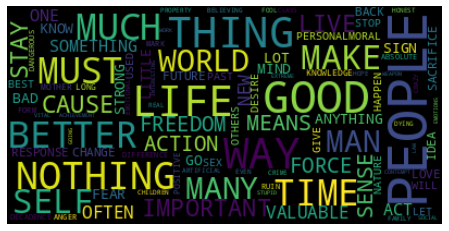

In [2]:
#look at the data and generate a word cloud

data = open('truisms.txt', encoding="utf8").read()

#word cloud time!
wordcloud = WordCloud(max_font_size=50,
                 max_words=100,
                 background_color="black").generate(data)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [3]:
artist_file = 'truisms.txt'
with open(artist_file) as f: # The with keyword automatically closes the file when you are done
    print (f.read(1000))

A LITTLE KNOWLEDGE CAN GO A LONG WAY

A LOT OF PROFESSIONALS ARE CRACKPOTS

A MAN CAN'T KNOW WHAT IT IS TO BE A MOTHER

A NAME MEANS A LOT JUST BY ITSELF

A POSITIVE ATTITUDE MEANS ALL THE DIFFERENCE IN THE WORLD

A RELAXED MAN IS NOT NECESSARILY A BETTER MAN

A SENSE OF TIMING IS THE MARK OF GENIUS

A SINCERE EFFORT IS ALL YOU CAN ASK

A SINGLE EVENT CAN HAVE INFINITELY MANY INTERPRETATIONS

A SOLID HOME BASE BUILDS A SENSE OF SELF

A STRONG SENSE OF DUTY IMPRISONS YOU

ABSOLUTE SUBMISSION CAN BE A FORM OF FREEDOM

ABSTRACTION IS A TYPE OF DECADENCE

ABUSE OF POWER COMES AS NO SURPRISE

ACTION CAUSES MORE TROUBLE THAN THOUGHT

ALIENATION PRODUCES ECCENTRICS OR REVOLUTIONARIES

ALL THINGS ARE DELICATELY INTERCONNECTED

AMBITION IS JUST AS DANGEROUS AS COMPLACENCY

AMBIVALENCE CAN RUIN YOUR LIFE

AN ELITE IS INEVITABLE

ANGER OR HATE CAN BE A USEFUL MOTIVATING FORCE

ANIMALISM IS PERFECTLY HEALTHY

ANY SURPLUS IS IMMORAL

ANYTHING IS A LEGITIMATE AREA OF INVESTIGATION

ARTIFICIAL DESIRE

In [4]:
def plotWordFrequency(input):
    f = open(artist_file,'r')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (data), fontsize=24)
    plt.show()

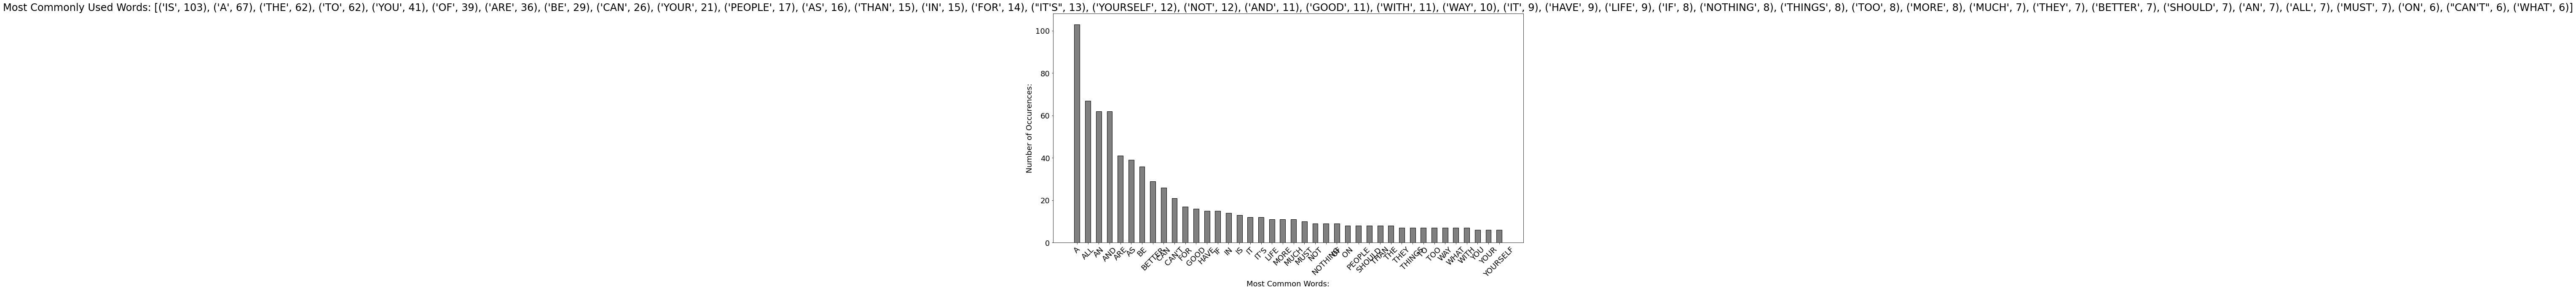

In [5]:
artist_file = 'truisms.txt'
plotWordFrequency(artist_file)

In [6]:
#now let's make a corpus for easier hanndling 
#i will split the data into lines 
corpus = data.upper().split("\n")
print(corpus[:10])


['A LITTLE KNOWLEDGE CAN GO A LONG WAY', '', 'A LOT OF PROFESSIONALS ARE CRACKPOTS', '', "A MAN CAN'T KNOW WHAT IT IS TO BE A MOTHER", '', 'A NAME MEANS A LOT JUST BY ITSELF', '', 'A POSITIVE ATTITUDE MEANS ALL THE DIFFERENCE IN THE WORLD', '']


In [7]:
type(corpus)

list

In [8]:
#fit onto tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
  
# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)
  
print("Total Words:", total_words)

Total Words: 803


In [9]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
  
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
  
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len,
                                         padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

In [10]:
# Building a Bi-Directional LSTM Model
#this is a tensor flow model 
model = Sequential()
model.add(Embedding(total_words+1, 100, 
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 100)           80400     
_________________________________________________________________
bidirectional (Bidirectional (None, 12, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 12, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 803)               81103     
_________________________________________________________________
dense_1 (Dense)              (None, 804)               646416    
Total params: 1,269,519
Trainable params: 1,269,519
Non-trainable params: 0
______________________________________________

In [48]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
49/49 [==============================] - 3s 65ms/step - loss: 0.3099 - accuracy: 0.9371
Epoch 2/150
49/49 [==============================] - 2s 44ms/step - loss: 0.3084 - accuracy: 0.9377
Epoch 3/150
49/49 [==============================] - 2s 38ms/step - loss: 0.3123 - accuracy: 0.9351
Epoch 4/150
49/49 [==============================] - 2s 41ms/step - loss: 0.3138 - accuracy: 0.9371
Epoch 5/150
49/49 [==============================] - 2s 39ms/step - loss: 0.3053 - accuracy: 0.9396
Epoch 6/150
49/49 [==============================] - 2s 39ms/step - loss: 0.3043 - accuracy: 0.9377
Epoch 7/150
49/49 [==============================] - 2s 40ms/step - loss: 0.2990 - accuracy: 0.9409
Epoch 8/150
49/49 [==============================] - 2s 40ms/step - loss: 0.3909 - accuracy: 0.9247
Epoch 9/150
49/49 [==============================] - 2s 40ms/step - loss: 0.3783 - accuracy: 0.9293
Epoch 10/150
49/49 [==============================] - 2s 41ms/step - loss: 0.3584 - accuracy: 0.9358

49/49 [==============================] - 3s 53ms/step - loss: 0.2595 - accuracy: 0.9345
Epoch 82/150
49/49 [==============================] - 3s 57ms/step - loss: 0.2601 - accuracy: 0.9364
Epoch 83/150
49/49 [==============================] - 3s 57ms/step - loss: 0.2585 - accuracy: 0.9371
Epoch 84/150
49/49 [==============================] - 3s 56ms/step - loss: 0.2626 - accuracy: 0.9364
Epoch 85/150
49/49 [==============================] - 3s 64ms/step - loss: 0.2568 - accuracy: 0.9377
Epoch 86/150
49/49 [==============================] - 3s 62ms/step - loss: 0.2569 - accuracy: 0.9371
Epoch 87/150
49/49 [==============================] - 3s 60ms/step - loss: 0.2590 - accuracy: 0.9371
Epoch 88/150
49/49 [==============================] - 3s 56ms/step - loss: 0.2665 - accuracy: 0.9338
Epoch 89/150
49/49 [==============================] - 3s 58ms/step - loss: 0.2591 - accuracy: 0.9371
Epoch 90/150
49/49 [==============================] - 3s 65ms/step - loss: 0.2587 - accuracy: 0.9371
Epo

In [50]:
seed_text = "The world"
next_words = 10
ouptut_text = ""
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
      
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
              
    seed_text += " " + output_word
      
print(seed_text)

The world operates according to discoverable laws rewarded to girls yourself and


In [14]:
seed_text = "I am"
next_words = 8
ouptut_text = ""
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
      
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
              
    seed_text += " " + output_word
      
print(seed_text)

I am must know where you stop and the world


In [15]:
seed_text = "you are"
next_words = 8
ouptut_text = ""
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
      
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
              
    seed_text += " " + output_word
      
print(seed_text)

you are guileless in your dreams money to charity with


In [16]:
seed_text = "pain"
next_words = 9
ouptut_text = ""
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
      
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
              
    seed_text += " " + output_word
      
print(seed_text)

pain can be a very little information about yourself for


In [51]:
def holzer_gen(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
          padding='pre')
        predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
        output_word = ""
      
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
              
        seed_text += " " + output_word
    
    return seed_text

In [20]:
seed_text = "Help me"
next_words = 5

holzer_gen(seed_text, next_words)

'Help me jaded romance can make it'

In [21]:
seed_text = "Taco"
next_words = 9

holzer_gen(seed_text, next_words)

'Taco must know where you stop and the world begins'

In [ ]:
seed_text = "Taco"
next_words = 9

holzer_gen(seed_text, next_words)

In [22]:
seed_text = "destroy the"
next_words = 9

holzer_gen(seed_text, next_words)

'destroy the idea of revolution is an adolescent fantasy life time'

In [28]:
seed_text = "you should"
next_words = 20

holzer_gen(seed_text, next_words)

'you should study as much as possible as plastic as possible as possible run run run run run new run new run'

In [29]:
seed_text = "how many"
next_words = 15

holzer_gen(seed_text, next_words)

'how many that your life stays in flux by equally consequences people is run but run may'

In [34]:
seed_text = "when i die i will"
next_words = 5

holzer_gen(seed_text, next_words)

'when i die i will have clean on the future'

In [35]:
seed_text = "i miss you"
next_words = 9

holzer_gen(seed_text, next_words)

'i miss you must be intimate with a token few immutable truths'

In [36]:
seed_text = "when you die"
next_words = 9

holzer_gen(seed_text, next_words)

'when you die to stay clean on all levels they were behave'

In [24]:
seed_text = "when you are twenty two"
next_words = 8

holzer_gen(seed_text, next_words)

'when you are twenty two an irresistible indifference is a powerful personal weapon'

In [ ]:
seed_text = "when you are twenty two"
next_words = 8

holzer_gen(seed_text, next_words)

In [45]:
seed_text = "defenestrate"
next_words = 8

holzer_gen(seed_text, next_words)

'defenestrate must be intimate with a token few immutable'

In [53]:
seed_text = "jenny holzer"
next_words = 8

holzer_gen(seed_text, next_words)

'jenny holzer must be intimate with a token few defeat'

In [52]:
seed_text = "why"
next_words = 8

holzer_gen(seed_text, next_words)

'why must be intimate with a token few defeat'

In [ ]:
#lets get more data!! 

In [44]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from mimetypes import guess_extension;
from base64 import b64decode;
from threading import Thread;
import requests;
from time import sleep;
import os;

ModuleNotFoundError: No module named 'selenium'

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from mimetypes import guess_extension;
from base64 import b64decode;
from threading import Thread;
import requests;
from time import sleep;
import os;

def download_image(img_src):
    img_index = hash(img_src);
    if img_src.startswith("http"):
        # Gotta stream it if it is big
        img_response = requests.get(img_src, stream=True);
        mime_type = img_response.headers['content-type']
        file_extension = guess_extension(mime_type);
        output_file = "./data/image_{}{}".format(img_index, file_extension);
        if os.path.exists(output_file):
            print("Image file exists: " + output_file);
        else:
            with open(output_file, "wb") as image:
                for buffer_data in img_response.iter_content():
                    image.write(buffer_data);
                print("Wrote an image: " + output_file);
        
    elif img_src.startswith("data:image"):
        mime_type = img_src[:img_src.index(";")].split(":")[1];
        file_extension = guess_extension(mime_type);
        output_file = "./data/image_{}{}".format(img_index, file_extension);
        if os.path.exists(output_file):
            print("Image file exists: " + output_file);
        else:
            with open(output_file, "wb") as image:
                image.write(b64decode(img_src[img_src.index(","):]));
                print("Wrote an image: " + output_file);
    
    else:
        print("Image not supported" + img_src[:55]);
   
def download_google_image_feed(browser: webdriver.Chrome, browser_wait: WebDriverWait):
    img_index = 0;
    done_downloading = False;
    while not done_downloading:
        # Need to keep forcing scrolling...
        while True:
            try:
                print("Scrolling down to bottom");
                browser.execute_script("window.scrollBy(0, document.body.scrollHeight)");
                try:
                    show_more_button = WebDriverWait(browser, 1).until(expected_conditions.visibility_of_element_located((By.XPATH, "//input[@value='Show more results']")))
                    show_more_button.click();
                except:
                    pass;
                
                try:
                    WebDriverWait(browser, 1).until(expected_conditions.visibility_of_element_located((By.XPATH, "//div[text()=\"Looks like you've reached the end\"]")));
                    print("Out of images to grab");
                    done_downloading = True;
                    break;
                except:
                    pass;
                sleep(1);
                browser_wait.until(
                    expected_conditions.presence_of_element_located((By.XPATH, "(//div[@data-root-margin-pages]//img[@width])[{}]".format(img_index+1)))
                );
                break;
            except:
                print("Failed to scroll to the bottom for some reason...");
                break;
        sleep(2);
        #get the images
        images = browser.find_elements(by=By.XPATH, value="//div[@data-root-margin-pages]//img[@width]");
        threads = list();
        for image in images[img_index:]:
            # images thumbnails are encoded in base64, we really only need those for small models... Can explore getting the source when needed.
            img_src = image.get_attribute("src");
            
            if img_src is None:
                print("Did not get an image for element...");
                print(image.id);
                continue;

            download_image(img_src);
            thread_task = Thread(target=download_image, args=(img_src,))
            threads.append(thread_task);
            thread_task.start()
        
            img_index = img_index + 1;
        
        for index, thread in enumerate(threads):
            thread.join();

def main():
    # Setup a browser for use to use and click around and scrape, bc we need to do that to get data now.
    chromedriver = "/opt/homebrew/bin/chromedriver";
    chromedriver_options = Options();
    # chromedriver_options.add_argument("--headless");
    
    browser: webdriver.Chrome = webdriver.Chrome(chromedriver, chrome_options=chromedriver_options);
    browser_wait = WebDriverWait(browser, 30);
    
    print("Google Boi, Google");
    
    # Nice blog that covers some url params we can use to scrape data
    # https://stenevang.wordpress.com/2013/02/22/google-advanced-power-search-url-request-parameters/
    # but screw it we only want some feet
    browser.get("https://www.google.com/search?q=hot+dirty+foot+fetish&tbm=isch");